In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\MishaYuliaAlina\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
heart_data = pd.read_csv('heart.csv')

Посмотрим на наши данные, какого они типа и что из себя представляют. Всего 12 параметров и одна целевая переменная. пропцщенных значений нет - на первый взгляд выглядит как идеальный датасет

In [3]:
heart_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Есть смысл не тратить время и сформировать отчет на основе pandas profilling

In [6]:
heart_report = heart_data.profile_report(title="Heart Disease UCI https://archive.ics.uci.edu/ml/datasets/Heart+Disease")
heart_report.to_file(output_file="heart_disease_uci.html")
heart_report

Для каждой фичи проверим распределение и построим графики относительной целевой переменной

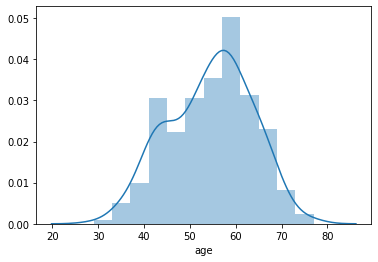

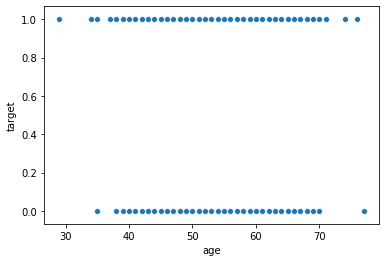

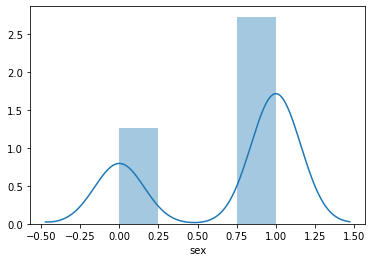

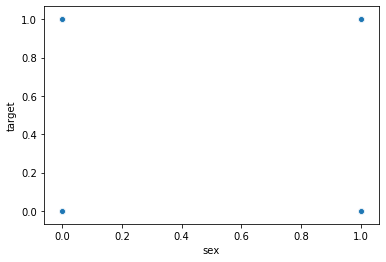

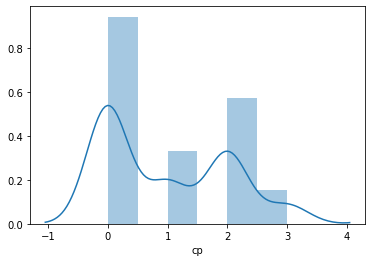

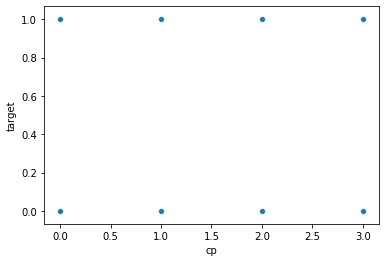

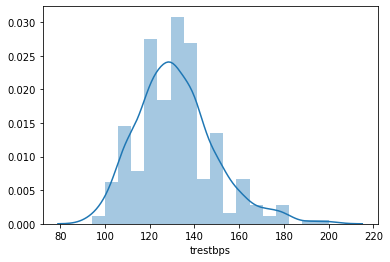

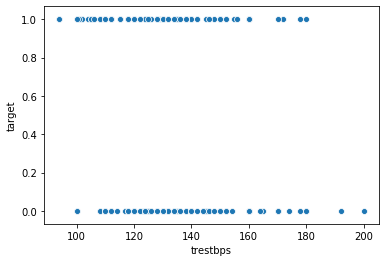

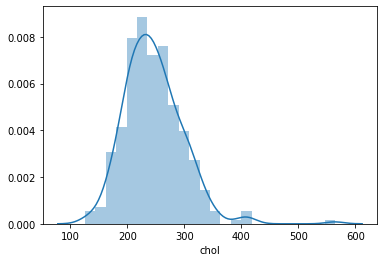

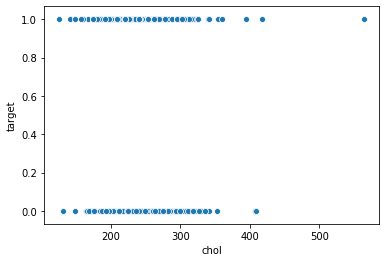

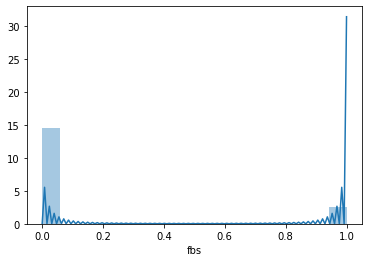

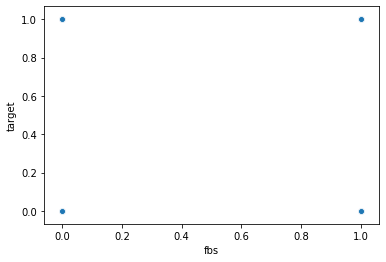

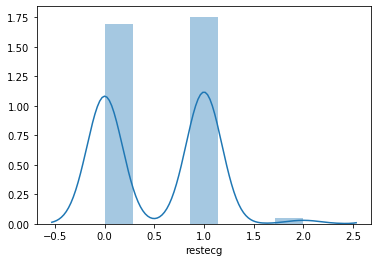

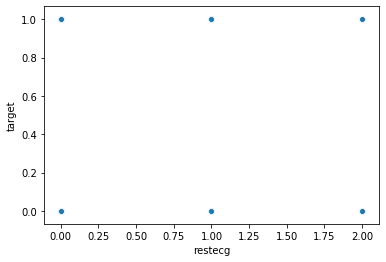

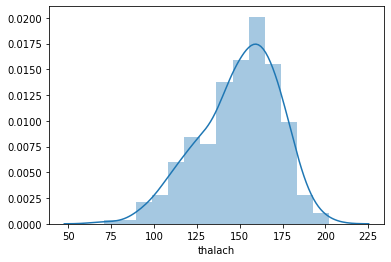

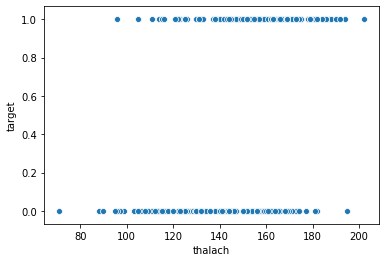

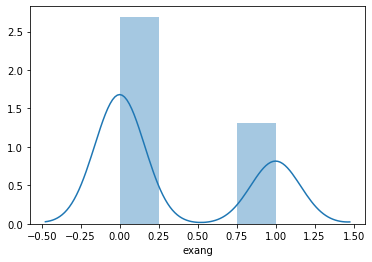

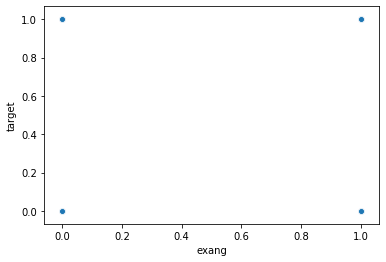

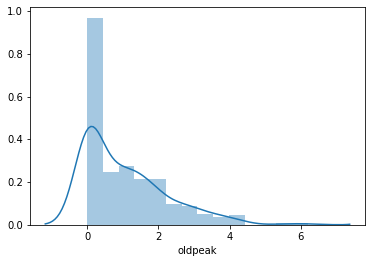

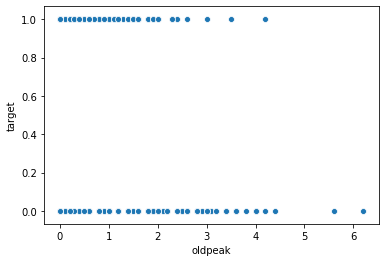

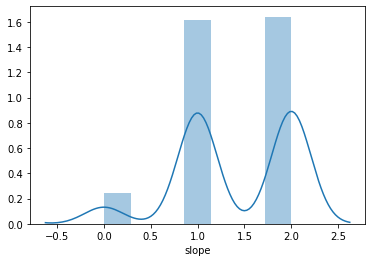

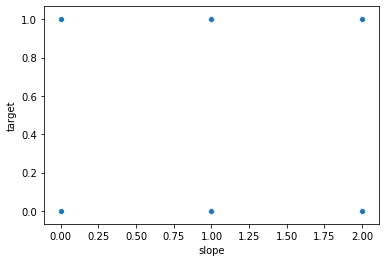

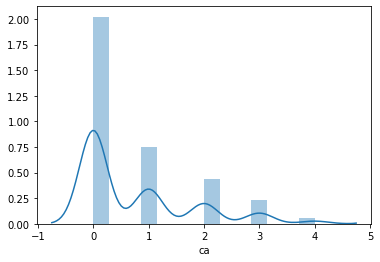

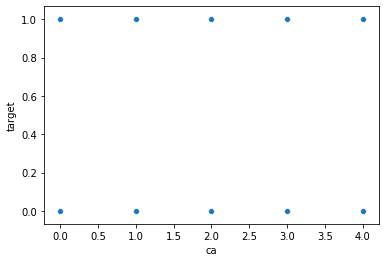

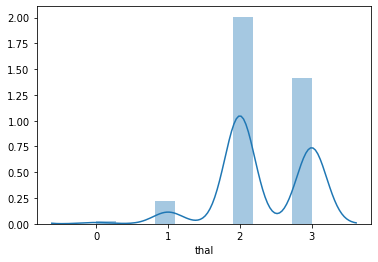

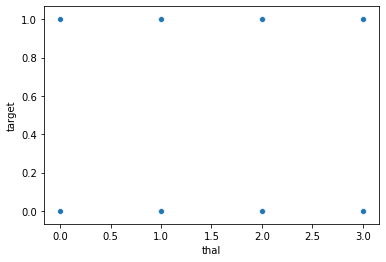

In [23]:
columns = list(heart_data.columns)

for i, col in enumerate(columns):
    if col != 'target':
        sns.distplot(heart_data[col])
        plt.show();
        sns.scatterplot(x=col, y="target", data=heart_data)
        plt.show();

In [ ]:
Все параметры отлично разделимы, выбросы отсутствуют - просто идеальные условия для обучения модели. Хотя в отчете и построены корреляции, есть смысл посмотреть на числовые значения.

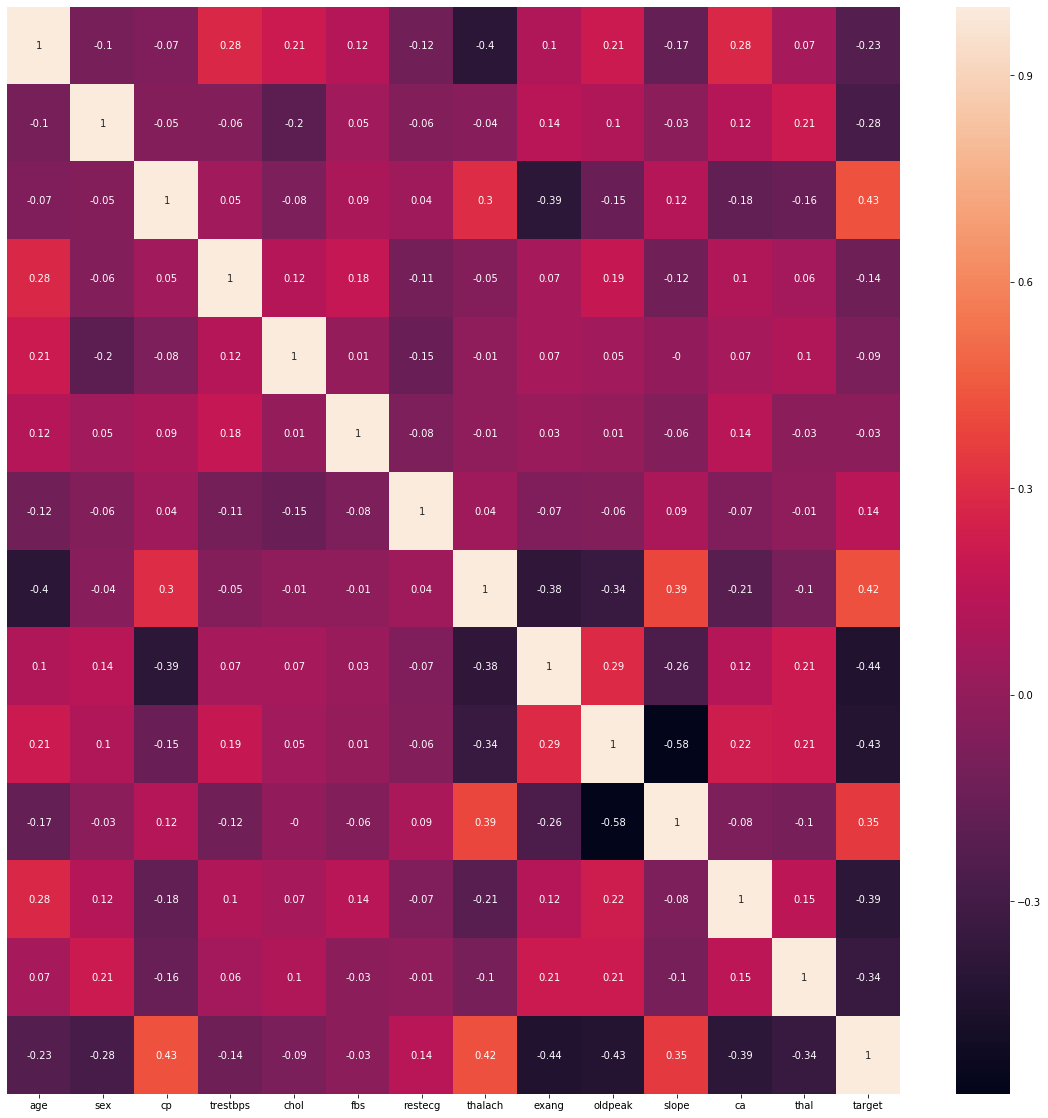

In [40]:
plt.figure(figsize=(20,20))
correlation_matrix = heart_data.corr().round(2)
sns.heatmap(data=correlation_matrix, yticklabels=False, annot=True)

Мне не очень нравится fbs - совсем маленькая корреляция с таргетом. oldpeak коррелирует со многими фичами - тоже выглядит не очень перспективно. Попробуем обучиться на логистической регрессии из sklearn.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [35]:
X = pd.DataFrame(np.c_[
    heart_data.age,
    heart_data.sex,
    heart_data.cp, 
    heart_data.restecg, 
    heart_data.thalach, 
    heart_data.exang,
    heart_data.chol,
    heart_data.oldpeak,
    heart_data.fbs,
    heart_data.slope,
    heart_data.ca,
    heart_data.thal
])

y = heart_data.target


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [37]:
clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train,Y_train)

In [38]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

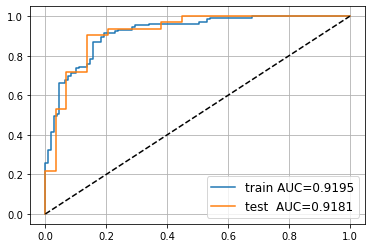

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train, Y_train, clf),
    ('test ', X_test, Y_test, clf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Окей, вроде бы отличный результат, можно попробовать его улучшить - есть смысл отказаться от fbs и oldpeak.

In [256]:
X = pd.DataFrame(np.c_[
    heart_data.age,
    heart_data.sex,
    heart_data.cp, 
    heart_data.restecg, 
    heart_data.thalach, 
    heart_data.exang,
    heart_data.chol,
    heart_data.slope,
    heart_data.ca,
    heart_data.thal
])

y = heart_data.target

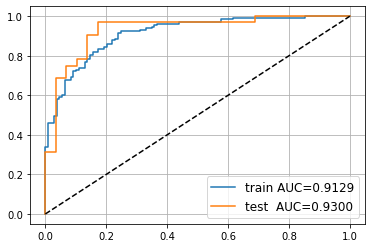

In [257]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train,Y_train)

for name, X, y, model in [
    ('train', X_train, Y_train, clf),
    ('test ', X_test, Y_test, clf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Площадь под кривой на тесте стала 93%, оставляем так

Попробуем погенерить синтетические данные для тестов. Берем от рельных данных среднее и дисперсию и дальше сэмплируем для каждой фичи из нормального распределения.

In [42]:
from scipy.stats import multivariate_normal, ks_2samp
import random

In [219]:
columns = list(heart_data.columns)
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
scip_cols = {'fbs', 'oldpeak'}

test_params = np.zeros((heart_data.shape[1], 2))
for i, col in enumerate(columns):
    if col not in scip_cols:
        if col not in set(categorical_cols):
            test_params[i][0] = np.mean(heart_data[col]) #mean
            test_params[i][1] = np.cov(heart_data[col]) #cov
        else:
            test_params[i][0] = np.mean(heart_data[col])#np.min(heart_data[col])
            test_params[i][1] = np.cov(heart_data[col])#np.max(heart_data[col])

KstestResult(statistic=0.07432343234323432, pvalue=0.3512155388657744)


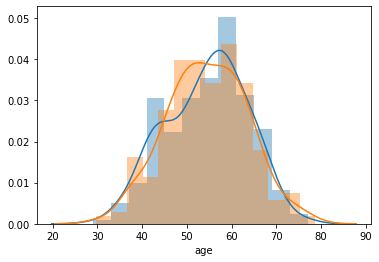

KstestResult(statistic=0.45983498349834984, pvalue=7.771561172376096e-16)


C:\Users\IVANKIN\anaconda4\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


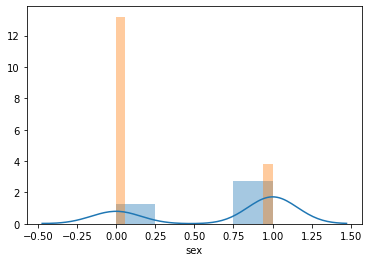

KstestResult(statistic=0.17636963696369637, pvalue=0.00013929786441346792)


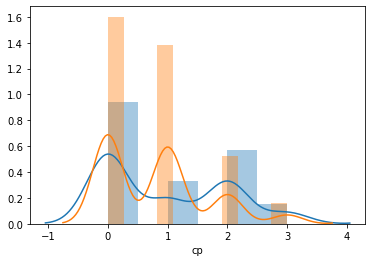

KstestResult(statistic=0.11346534653465347, pvalue=0.03681069016277161)


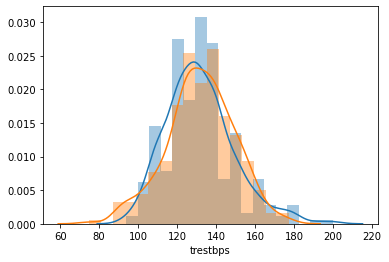

KstestResult(statistic=0.06871287128712872, pvalue=0.4453946680992852)


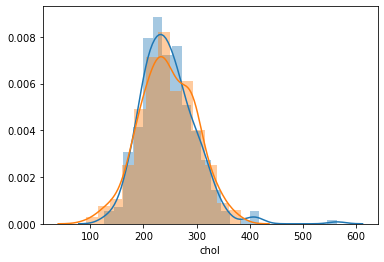

KstestResult(statistic=0.3481848184818482, pvalue=7.771561172376096e-16)


C:\Users\IVANKIN\anaconda4\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


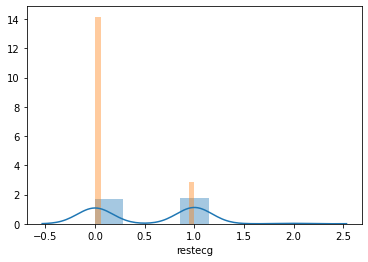

KstestResult(statistic=0.09768976897689768, pvalue=0.10246229005115004)


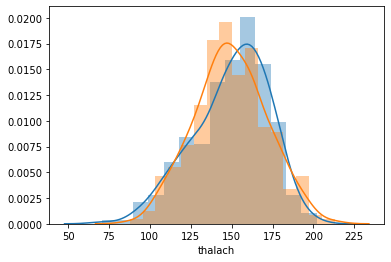

KstestResult(statistic=0.2533993399339934, pvalue=5.343151254777467e-09)


C:\Users\IVANKIN\anaconda4\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


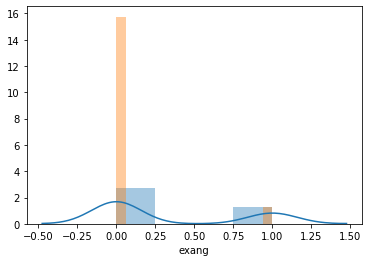

C:\Users\IVANKIN\anaconda4\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


KstestResult(statistic=0.3053135313531353, pvalue=6.274980535181385e-13)


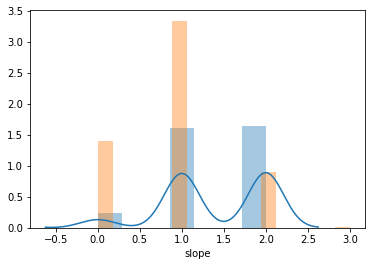

KstestResult(statistic=0.10458745874587459, pvalue=0.06686689008663105)


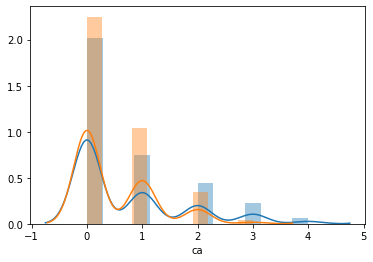

KstestResult(statistic=0.24732673267326732, pvalue=1.294635754156559e-08)


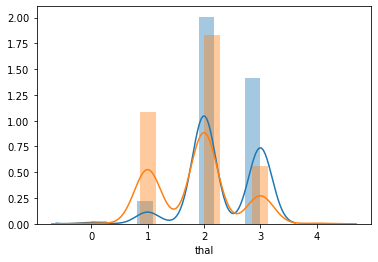

KstestResult(statistic=0.3812211221122112, pvalue=7.771561172376096e-16)


C:\Users\IVANKIN\anaconda4\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


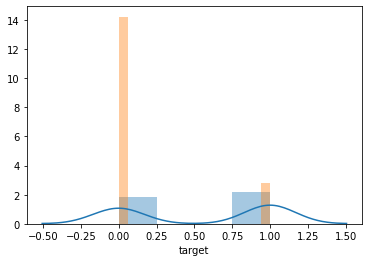

In [220]:
SAMPLE_SIZE = 300

samples_dict = dict()

for i, col in enumerate(columns):
    if col not in scip_cols:    
        if col not in set(categorical_cols):
            distr = multivariate_normal(mean=test_params[i][0], cov=test_params[i][1], allow_singular=False)
            sampling = distr.rvs(SAMPLE_SIZE)
        else:
            distr = multivariate_normal(mean=test_params[i][0], cov=test_params[i][1], allow_singular=False)
            sampling = np.abs((distr.rvs(SAMPLE_SIZE)).astype(int)) #[random.randint(test_params[i][0], test_params[i][1]) for _ in range(SAMPLE_SIZE)]

        samples_dict[col] = sampling
        
        sns.distplot(heart_data[col])
        sns.distplot(sampling)
        print(ks_2samp(heart_data[col], sampling))
        plt.show();